In [1]:
import numpy as np  
import pandas as pd 
import sys
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from mlens.ensemble import SuperLearner
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import f_classif, mutual_info_classif
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
def missing_data(df):
    '''
    Функция отображает название признака, количество пропщуенных значений и их процент от общего количества.
    '''
    for column in df.columns:
        missing = df[column].isnull().sum()
        percent_of_missing = np.mean(df[column].isnull())
        if missing > 0:
            print(f'{column} - {missing} value(s), {percent_of_missing*100:.2f}%')


def duplicate_data(df):
    '''
    Функция для поиска дубликатов.
    '''
    if len(df) > len(df.drop_duplicates()):
        print('Имеются дубликаты')
        display(df[df.duplicated()])
    else:
        print('Дубликатов не обнаружено')


def IQR_outlier(df, column, mode='analysis', verbose=True):
    '''
    Функция отображения выбросов 
    '''
    perc25 = np.percentile(df[column], 25, axis=0)
    perc75 = np.percentile(df[column], 75, axis=0)
    IQR = perc75 - perc25
    low = perc25 - 1.5*IQR
    high = perc75 + 1.5*IQR
    anomaly = len(df[df[column] > high]) + \
        len(df[df[column] < low])
    if verbose:
        if mode == 'analysis':
            print(f'Наименование признака: {column}')
            print('25-й перцентиль: {},'.format(perc25)[:-1], '75-й перцентиль: {},'.format(perc75),
                  'IQR: {}, '.format(IQR), 'Границы выбросов: [{f}, {l}].'.format(f=low, l=high))
            print(
                f'Выбросов, согласно IQR: {anomaly} | {anomaly/len(df):2.2%}')
        elif mode == 'correction':
            return low, high


def get_log(df, column):
    '''
    Функция логарифмирования.
    '''
    return df[column].apply(lambda x: np.log(x + 1))


def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [4]:
# Загрузим данные предоставленные Kagle
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [5]:
# Рассмотрим тестовый датасет
test.head(5)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,...,LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,...,LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,...,LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

## Посмотрим какие у нас имеются данные в test
#### Датасет состоит из 32 столбцов, содержащих следующую информацию:
- bodyType: Тип кузова;
- brand: бренд автомобиля;
- car_url: ссылка на объявление;
- color: цвет;
- complictation_dict: комплектация автомобиля;
- description: описание;
- engineDisplacement: объем двигателя;
- enginePower: мощность двигателя;
- equipment_dict: список имеющегося оборудования;
- fuelType: тип используемого топлива;
- image: изображения автомобиля;
- mileage: пробег;
- modelDate: год выпуска модели;
- model_info : информация о модели;
- model_name : имя модели;
- name : наименование модели с характеристиками;
- numberOfDoors : количество дверей;
- parsing_unixtime : время взятия данных в формате unixtime;
- priceCurrency: Валюта;
- productionDate: Год производства;
- sell_id: id объявления;
- super_gen: список данных о модели;
- vehicleConfiguration: Тип кузова, тип коробки передач и объем двигателя;
- vehicleTransmission: тип коробки передачи;
- vendor: страна производитель;
- Владельцы;
- Владение;
- ПТС;
- Привод;
- Руль;
- Состояние;
- Таможня.

Для понимания какие данным нам необходимо дополнительно собрать для построения модели, проанализирую данные имеющиеся в тесте. Первое, что меня заинтересовало, это дата получения данных. От этого будет зависеть подбор тестовых данных, так как цены меняются с течением времени.

In [7]:
# Посмотри за какой период представлены данные в тесте
print(pd.to_datetime(test.parsing_unixtime.min(), unit='s'))
print(pd.to_datetime(test.parsing_unixtime.max(), unit='s'))

2020-10-19 11:35:06
2020-10-26 11:04:24


Данные в тестовом датасете представлены на октябрь 2020 года, в идеале для тренировочного датасета иметь данные за аналогичный период. Посмотрим на данные представленные в Baseline для данной задачи.

In [8]:
train = pd.read_csv('all_auto_ru_09_09_2020.csv')

In [9]:
train.head()

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model
0,Седан,AUDI,040001,бензин,1990.0,2.8 MT (174 л.с.) 4WD,4.0,1991,SEDAN MECHANICAL 2.8,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,200000.0,2019-10-03T08:09:11Z,NaN,100
1,Седан,AUDI,EE1D19,бензин,1982.0,1.8 MT (90 л.с.),4.0,1986,SEDAN MECHANICAL 1.8,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,60000.0,2020-09-06T06:49:40Z,NaN,100
2,Универсал 5 дв.,AUDI,0000CC,бензин,1988.0,2.3 MT (136 л.с.) 4WD,5.0,1989,WAGON_5_DOORS MECHANICAL 2.3,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,99000.0,2020-09-02T14:04:21Z,NaN,100
3,Седан,AUDI,CACECB,бензин,1988.0,1.8 MT (90 л.с.),4.0,1989,SEDAN MECHANICAL 1.8,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,65000.0,2020-08-23T17:40:09Z,NaN,100
4,Седан,AUDI,040001,бензин,1990.0,2.0 MT (101 л.с.),4.0,1991,SEDAN MECHANICAL 2.0,MECHANICAL,...,LEFT,NaN,3.0,DUPLICATE,True,NaN,100000.0,2020-09-08T09:22:07Z,NaN,100


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89378 entries, 0 to 89377
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              89377 non-null  object 
 1   brand                 89378 non-null  object 
 2   color                 89378 non-null  object 
 3   fuelType              89378 non-null  object 
 4   modelDate             89377 non-null  float64
 5   name                  89377 non-null  object 
 6   numberOfDoors         89377 non-null  float64
 7   productionDate        89378 non-null  int64  
 8   vehicleConfiguration  89377 non-null  object 
 9   vehicleTransmission   89377 non-null  object 
 10  engineDisplacement    89377 non-null  object 
 11  enginePower           89377 non-null  float64
 12  description           86124 non-null  object 
 13  mileage               89378 non-null  int64  
 14  Комплектация          89378 non-null  object 
 15  Привод             

In [11]:
# Дата получения информации в train представленна в признаке start_date, посмотри период сбора информации:
# for date in train['start_date']:
#  pd.to_datetime(s, format="%d%m%Y", errors="coerce").fillna(pd.to_datetime(s, format="%d%b%Y", errors="coerce"))
train['date'] = pd.to_datetime(train['start_date'], format='%Y-%m-%dT%H:%M:%SZ',
                               errors="coerce").fillna(pd.to_datetime(train['start_date'],
                                                                      format="%Y-%m-%dT%H:%M:%S.%fZ", errors="coerce"))
print(train['date'].min())
print(train['date'].max())

2014-06-10 06:27:00
2020-09-09 10:49:25


In [12]:
# Посмотрим сколько данных есть за 2020 год
print(len(train[train['date'] > '2020-01-01']))
# За второе полугодие 2020 года
print(len(train[train['date'] > '2020-06-01']))

75752
59823


На основе данных собранных в датасете train и количестве данных за второе полугодие 2020 года. В связи с изменением цен и трудоемкости сборки новых данных посредством парсинга ресурсов, принимаю решение взять для обучения данные представленные в Baseline train.

## Посмотрим какие у нас имеются данные в train
#### Датасет состоит из 26 столбцов, содержащих следующую информацию:
- bodyType: Тип кузова;
- brand: бренд автомобиля;
- color: цвет;
- fuelType: тип используемого топлива;
- modelDate: год выпуска модели;
- name : наименование модели с характеристиками;
- numberOfDoors : количество дверей;
- productionDate: Год производства;
- vehicleConfiguration: Тип кузова, тип коробки передач и объем двигателя;
- vehicleTransmission: тип коробки передачи;
- engineDisplacement: объем двигателя;
- enginePower: мощность двигателя;
- description: описание;
- mileage: пробег;
- Комплектация: комплектация автомобиля;
- Привод;
- Руль;
- Состояние;
- Владельцы;
- ПТС;
- Таможня;
- Владение;
- price: стоимость автомобиля (целевая переменная);
- start_date: дата размещения объявления;
- hidden: пустой признак;
- model: обозначение модели.

Для корректной обработки признаков необходимо объединить трейн и тест в один датасет, для этого подготовим и необходимые признаки в train. 

In [13]:
# Основываясь на описанном выше для обучения возьму данные за второе полугодие 2020 года.
train = train[train['date'] > '2020-06-01']

In [14]:
# признаки времени в дальнейшей обработки не будут использоваться, избавимся от них и пустого признака hidden
train.drop(['date', 'start_date', 'hidden'], axis=1, inplace=True)

In [15]:
# переименуем признаки train  в соответствии с test
train.rename(columns={'Комплектация': 'complectation_dict',
                      'model': 'model_name'}, inplace=True)

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59823 entries, 1 to 89377
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              59823 non-null  object 
 1   brand                 59823 non-null  object 
 2   color                 59823 non-null  object 
 3   fuelType              59823 non-null  object 
 4   modelDate             59823 non-null  float64
 5   name                  59823 non-null  object 
 6   numberOfDoors         59823 non-null  float64
 7   productionDate        59823 non-null  int64  
 8   vehicleConfiguration  59823 non-null  object 
 9   vehicleTransmission   59823 non-null  object 
 10  engineDisplacement    59823 non-null  object 
 11  enginePower           59823 non-null  float64
 12  description           57977 non-null  object 
 13  mileage               59823 non-null  int64  
 14  complectation_dict    59823 non-null  object 
 15  Привод             

In [17]:
# Проверим наличие дубликатов в тренировочных данных
duplicate_data(train)

Имеются дубликаты


,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,complectation_dict,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,model_name
38,Седан,AUDI,0000CC,бензин,1990.0,2.3 MT (133 л.с.),4.0,1992,SEDAN MECHANICAL 2.3,MECHANICAL,...,{'id': '0'},передний,LEFT,NaN,3.0,DUPLICATE,True,NaN,40000.0,100
170,Седан,AUDI,040001,бензин,1986.0,1.8 AT (90 л.с.),4.0,1990,SEDAN AUTOMATIC 1.8,AUTOMATIC,...,{'id': '0'},передний,LEFT,NaN,3.0,ORIGINAL,True,NaN,70000.0,80
351,Седан,AUDI,97948F,бензин,2016.0,1.4 AMT (150 л.с.),4.0,2020,SEDAN ROBOT 1.4,ROBOT,...,"{'id': '21597097', 'name': '35 TFSI S tronic',...",передний,LEFT,NaN,NaN,ORIGINAL,True,NaN,1946000.0,A3
369,Седан,AUDI,97948F,бензин,2016.0,1.4 AMT (150 л.с.),4.0,2020,SEDAN ROBOT 1.4,ROBOT,...,"{'id': '20838807', 'name': 'Basis', 'available...",передний,LEFT,NaN,NaN,ORIGINAL,True,NaN,1885400.0,A3
387,Седан,AUDI,97948F,бензин,2016.0,1.4 AMT (150 л.с.),4.0,2020,SEDAN ROBOT 1.4,ROBOT,...,"{'id': '20838807', 'name': 'Basis', 'available...",передний,LEFT,NaN,NaN,ORIGINAL,True,NaN,1885400.0,A3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88705,Внедорожник 5 дв.,SSANG_YONG,97948F,дизель,2010.0,2.0d AT (175 л.с.),5.0,2011,ALLROAD_5_DOORS AUTOMATIC 2.0d,AUTOMATIC,...,{'id': '0'},передний,LEFT,NaN,3.0,ORIGINAL,True,NaN,530000.0,ACTYON
88796,Внедорожник 5 дв.,SSANG_YONG,CACECB,бензин,2010.0,2.0 MT (149 л.с.) 4WD,5.0,2013,ALLROAD_5_DOORS MECHANICAL 2.0,MECHANICAL,...,"{'id': '7958369', 'name': 'Original', 'availab...",полный,LEFT,NaN,1.0,ORIGINAL,True,NaN,543000.0,ACTYON
89016,Внедорожник 5 дв.,SSANG_YONG,97948F,дизель,2007.0,6-speed 2.0d AT (141 л.с.) 4WD,5.0,2013,ALLROAD_5_DOORS AUTOMATIC 6-speed,AUTOMATIC,...,"{'id': '7864744', 'name': 'Luxury', 'available...",полный,LEFT,NaN,1.0,ORIGINAL,True,NaN,645000.0,KYRON
89017,Внедорожник 5 дв.,SSANG_YONG,97948F,дизель,2005.0,2.0d AT (141 л.с.) 4WD,5.0,2007,ALLROAD_5_DOORS AUTOMATIC 2.0d,AUTOMATIC,...,{'id': '0'},полный,LEFT,NaN,1.0,ORIGINAL,True,NaN,395000.0,KYRON


In [18]:
# удалим дубликаты в тренировочных данных
train = train.drop_duplicates()

In [19]:
# Проверим наличие дубликатов в тестовых данных
duplicate_data(test)

Дубликатов не обнаружено


In [82]:
# Для удобства обработки признаков объединяем тренировочные и тестовые данные в один датасет
train['sample'] = 1  # помечаем где тренировочные данные
test['sample'] = 0  # помечаем где тестовые данные
# в тестовых данных нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями
test['price'] = 0
# для дальнейшей обработки возьму все схожие признаки
columns = list(train)
df_train = train[columns]
df_test = test[columns]
# Для удобства обработки признаков объединяем тренировочные и тестовые данные в один датасет
data = df_test.append(df_train, sort=False).reset_index(
    drop=True)  # объединяем

In [83]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91270 entries, 0 to 91269
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              91270 non-null  object 
 1   brand                 91270 non-null  object 
 2   color                 91270 non-null  object 
 3   fuelType              91270 non-null  object 
 4   modelDate             91270 non-null  float64
 5   name                  91270 non-null  object 
 6   numberOfDoors         91270 non-null  float64
 7   productionDate        91270 non-null  int64  
 8   vehicleConfiguration  91270 non-null  object 
 9   vehicleTransmission   91270 non-null  object 
 10  engineDisplacement    91270 non-null  object 
 11  enginePower           91270 non-null  object 
 12  description           89443 non-null  object 
 13  mileage               91270 non-null  int64  
 14  complectation_dict    63002 non-null  object 
 15  Привод             

In [84]:
# Посмотрим какие типы признаков у нас могут быть:
data.nunique(dropna=False)

bodyType                  177
brand                      36
color                      32
fuelType                    5
modelDate                  71
name                     4330
numberOfDoors               5
productionDate             73
vehicleConfiguration     1815
vehicleTransmission         8
engineDisplacement        540
enginePower               692
description             77993
mileage                 21767
complectation_dict       7051
Привод                      3
Руль                        4
Состояние                   2
Владельцы                   7
ПТС                         5
Таможня                     2
Владение                  531
price                    7425
model_name               1021
sample                      2
dtype: int64

description - 1827 value(s), 2.00%
complectation_dict - 28268 value(s), 30.97%
Состояние - 56584 value(s), 62.00%
Владельцы - 9797 value(s), 10.73%
ПТС - 273 value(s), 0.30%
Владение - 63602 value(s), 69.69%
price - 399 value(s), 0.44%


<AxesSubplot:>

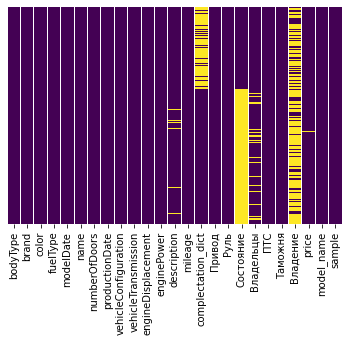

In [85]:
# Проверим данные на наличие пропусков:
missing_data(data)
# Посмотри наглядно на их распределения
sns.heatmap(data.isnull(), yticklabels=False,
            cbar=False, cmap='viridis')

### Сформулируем выводы:

- в данных представлено 24 признаков (25-й sample мы не считаем, так как он был искусствено создан для удобства разделения обучающей и тестовой выборки)
- в объединенном датасете 91270 наблюдений
- дубликаты присутствуют в train: 3239. Принял решение удалить их.
- имеются пропуски только в 7 признаках - description - 1827 value(s), 2.00%; complectation_dict - 28268 value(s), 30.97%; Состояние - 56584 value(s), 62.00%; Владельцы - 9797 value(s), 10.73%; ПТС - 273 value(s), 0.30%; Владение - 63602 value(s), 69.69%; price - 399 value(s), 0.44%. Рассмотрим их далее.

# Рассмотрим признаки

In [86]:
# Для упрощения дальнейшей работы создадим типовые списки признаков
df_cols = list(test)
num_cols = ['mileage', 'modelDate', 'numberOfDoors',
            'productionDate', 'price']  # 4 признака и целевое значение
bin_cols = ['ПТС', 'Руль', 'Состояние', 'Таможня']  # 4 призанка
cat_cols = ['bodyType', 'brand', 'color', 'fuelType',  'name',
            'vehicleConfiguration', 'vehicleTransmission', 'engineDisplacement',
            'enginePower', 'description', 'complectation_dict',
            'model_name', 'Владельцы', 'Владение', 'Привод']  # 15 признаков

# Работа с числовыми признаками

In [87]:
# Как мы опредилили ранее в числовых признаках имеются пропуски в 'price'.
# Так как это целевая переменная необходимая для обучения, избавимся от пропусков методом удаления
data.dropna(subset=['price'], inplace=True)

In [88]:
data[num_cols].head()

,mileage,modelDate,numberOfDoors,productionDate,price
0,74000,2013.0,5.0,2014,0.0
1,60563,2017.0,5.0,2017,0.0
2,88000,2013.0,5.0,2014,0.0
3,95000,2013.0,5.0,2014,0.0
4,58536,2008.0,5.0,2012,0.0


Наименование признака: mileage
25-й перцентиль: 43100.0 75-й перцентиль: 187000.0, IQR: 143900.0,  Границы выбросов: [-172750.0, 402850.0].
Выбросов, согласно IQR: 655 | 1.17%
Наименование признака: modelDate
25-й перцентиль: 2005.0 75-й перцентиль: 2015.0, IQR: 10.0,  Границы выбросов: [1990.0, 2030.0].
Выбросов, согласно IQR: 765 | 1.36%
Наименование признака: numberOfDoors
25-й перцентиль: 4.0 75-й перцентиль: 5.0, IQR: 1.0,  Границы выбросов: [2.5, 6.5].
Выбросов, согласно IQR: 1164 | 2.07%
Наименование признака: productionDate
25-й перцентиль: 2007.0 75-й перцентиль: 2017.0, IQR: 10.0,  Границы выбросов: [1992.0, 2032.0].
Выбросов, согласно IQR: 613 | 1.09%
Наименование признака: price
25-й перцентиль: 370000.0 75-й перцентиль: 1670000.0, IQR: 1300000.0,  Границы выбросов: [-1580000.0, 3620000.0].
Выбросов, согласно IQR: 4953 | 8.82%


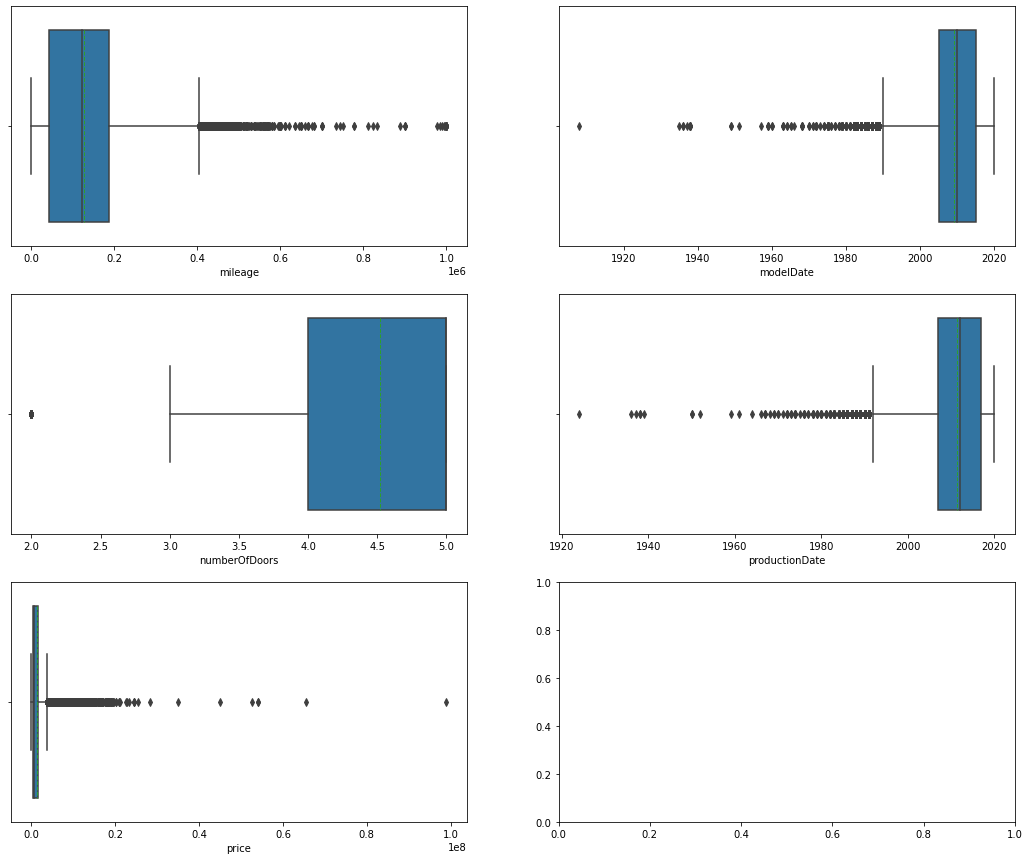

In [89]:
# Проведем анализ для выявления выбросов числовых признаков, для наглядности постоим boxplot:
fig, axes = plt.subplots(3, 2, figsize=(18, 15))
for i, column in enumerate(num_cols):
    sns.boxplot(x=data.query('sample == 1')[column],
                ax=axes.flat[i],
                showmeans=True,
                meanline=True,
                orient='h')
    IQR_outlier(data.query('sample == 1'), column)
    print('=='*20)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.55 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWar

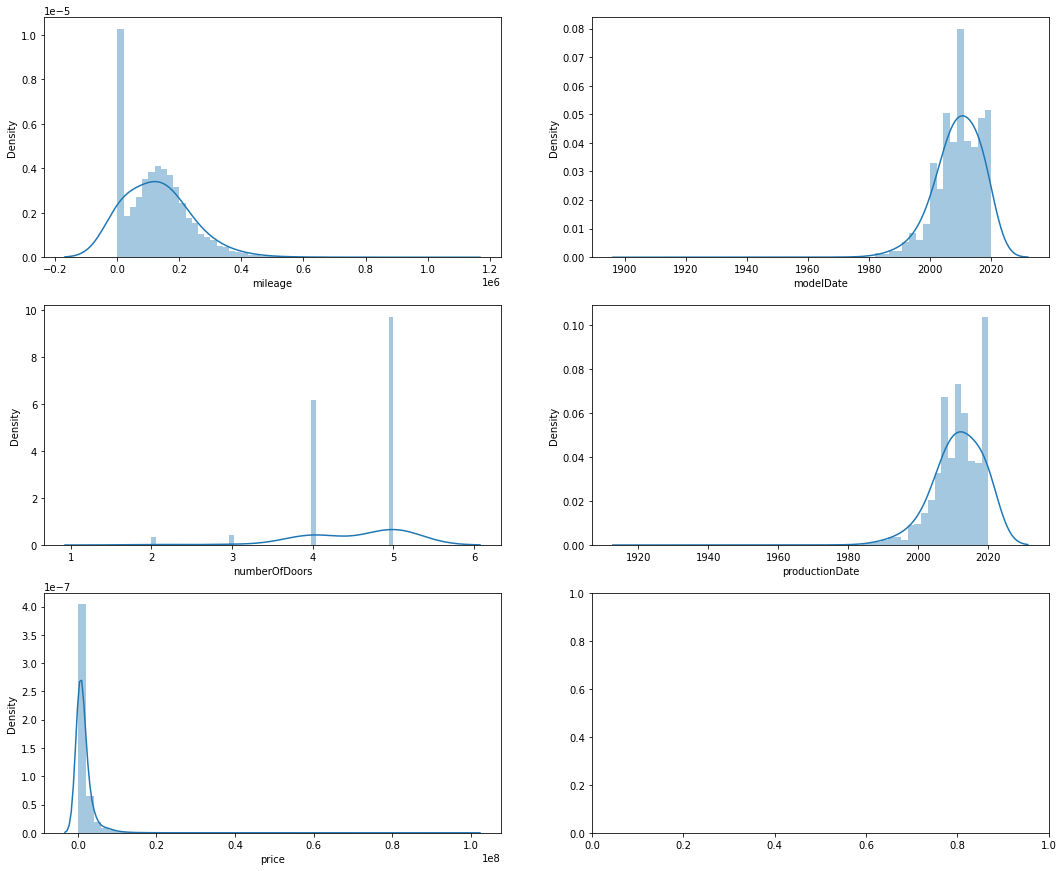

In [90]:
# Посмотрим на распределение признаков
fig, axes = plt.subplots(3, 2, figsize=(18, 15))
for i, col in enumerate(num_cols):
    sns.distplot(data.query('sample == 1')[
                 col], ax=axes.flat[i], bins=50, kde_kws={'bw': 0.55})

In [91]:
# Посмотрим статистику по числовым признакам:
data.query('sample == 1')[num_cols].describe()

,mileage,modelDate,numberOfDoors,productionDate,price
count,56185.000000,56185.000000,56185.000000,56185.000000,5.618500e+04
mean,127454.756056,2009.167838,4.517914,2011.441648,1.407421e+06
std,102529.599701,7.232356,0.650390,6.839444,2.004440e+06
min,0.000000,1908.000000,2.000000,1924.000000,1.600000e+04
25%,43100.000000,2005.000000,4.000000,2007.000000,3.700000e+05
50%,121924.000000,2010.000000,5.000000,2012.000000,7.000000e+05
75%,187000.000000,2015.000000,5.000000,2017.000000,1.670000e+06
max,1000000.000000,2020.000000,5.000000,2020.000000,9.900000e+07


### Промежуточные выводы:

- признак ***mileage*** - пробег. Минимальное значение - 0, максимальное - 1000000. Средний пробег авто - 12, медианный - 121924.Самое часто встречающееся значение 0. Есть смещение к 0, что говорит о большом кол-ве новых авто. Выбросы в данном признаке 655 | 1.17%, это авто со слишком большим пробегом. Имеет смылс логарифмировать признак.
- признак ***modelDate***. Значения от 1908 до 2020. Распределение смещено. Также присутствуют выбросы в количестве 765 | 1.36%, однако удалять данные о моделях выпущенных ранее 1990 года не вижу необходимости.
- признак ***numberOfDoors***. Минимальное значение - 2, максимальное - 5. Выбросов не имеет, в дальнейшей обработке не нуждается.
- признак ***productionDate***. Значения от 1924 до 2020. Распределение смещено. Также присутствуют выбросы в количестве 613 | 1.09%, однако удалять данные о моделях выпущенных ранее 1992 года не вижу необходимости.
- признак ***price*** - целевой признак. Минимальное значение - 1600, максимальное - 99000000. Средняя цена авто - 14074210. Распределение сильно смещено вправо. Выбросов, согласно IQR: 4953 | 8.82%, считаю важным обработать выбросы, а именно удалить значения выше 4000000.

In [92]:
# избавимся от выбросов в 'price'
data = data[data['price'] <= 4000000]
# Для дальнейшей обработки удалим целевой признак и списка
num_cols.remove('price')

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.45 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWar

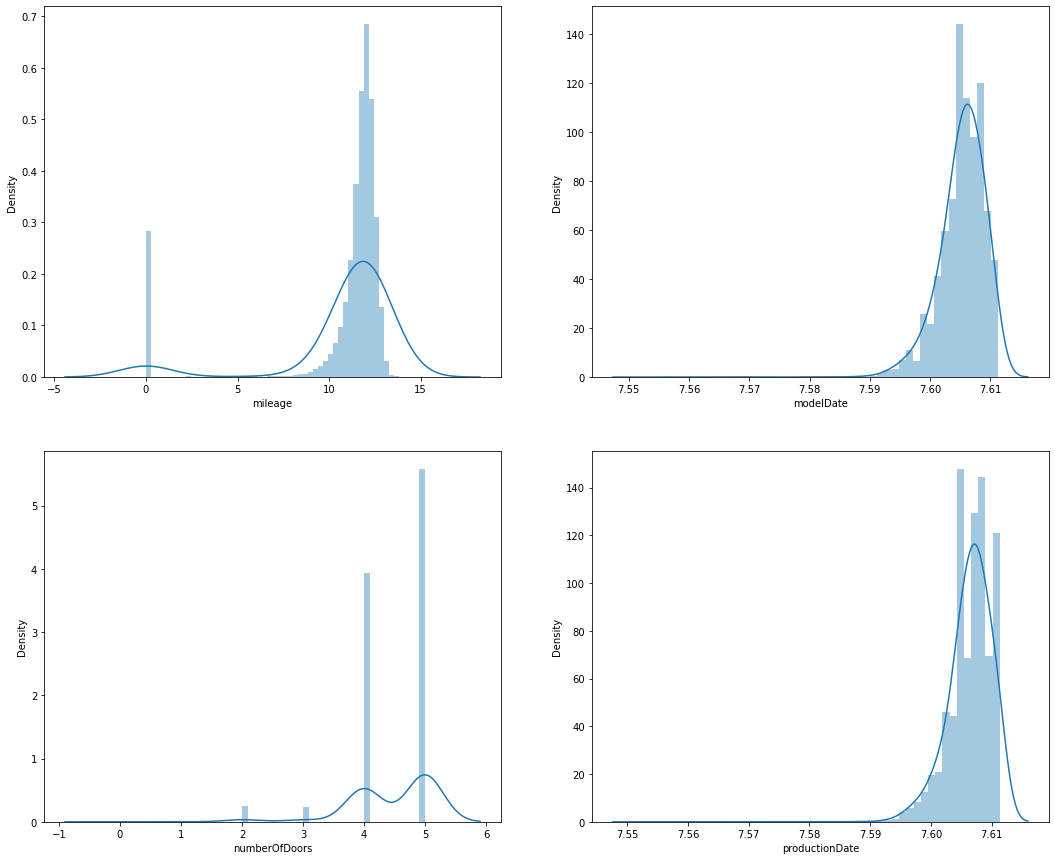

In [93]:
# Прологарифмируем признаки у которых смещенны распределения:
log_features = ['mileage', 'modelDate', 'productionDate']
for column in log_features:
    data[column] = get_log(data, column)
# Посмотрим на распределения числовых признаков после преобразований:
fig, axes = plt.subplots(2, 2, figsize=(18, 15))
for i, col in enumerate(num_cols):
    sns.distplot(data[col], ax=axes.flat[i], bins=50, kde_kws={'bw': 0.45})

# Корреляционный анализ

<AxesSubplot:>

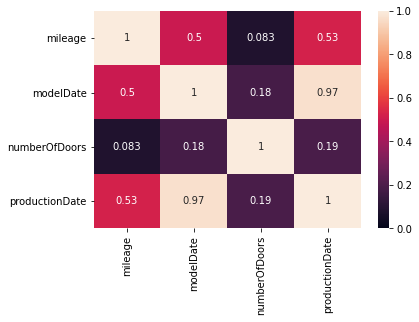

In [94]:
sns.heatmap(data[num_cols].corr().abs(), annot=True, vmin=0, vmax=1)

# Оценка значимости признаков

<AxesSubplot:>

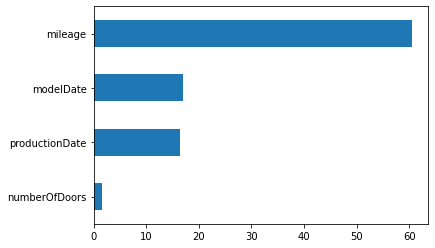

In [95]:
# Определим значимость числовых признаков с помощью функции mutual_info_classif:
imp_num = pd.Series(f_classif(data.query('sample == 1')[num_cols], data.query(
    'sample == 1')['price'])[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

**Резюме**: Максимальное значение коэффициента корреляции составляет 0,97 между признаками ***modelDate/productionDate***. Это говорит о большой связи этих параметров, что понятно исходя из логики связи года выпуска модели и года выпуска авто. Оценка значимости числовых признаков показывает, что все признаки в той или иной степени влияют на целевой. Самым значимым из чиловых признаков является ***mileage***.

# Категориальные признаки

In [96]:
data[cat_cols].head()

,bodyType,brand,color,fuelType,name,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,complectation_dict,model_name,Владельцы,Владение,Привод
0,лифтбек,SKODA,синий,бензин,1.2 AMT (105 л.с.),LIFTBACK ROBOT 1.2,роботизированная,1.2 LTR,105 N12,"Все автомобили, представленные в продаже, прох...",NaN,OCTAVIA,3 или более,NaN,передний
1,лифтбек,SKODA,чёрный,бензин,1.6 MT (110 л.с.),LIFTBACK MECHANICAL 1.6,механическая,1.6 LTR,110 N12,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,NaN,OCTAVIA,1 владелец,NaN,передний
2,лифтбек,SKODA,серый,бензин,DSG 1.8 AMT (152 л.с.),LIFTBACK ROBOT 1.8,роботизированная,1.8 LTR,152 N12,"Все автомобили, представленные в продаже, прох...","{""id"":""20026336"",""name"":""Ambition"",""available_...",SUPERB,1 владелец,NaN,передний
3,лифтбек,SKODA,коричневый,бензин,1.6 AT (110 л.с.),LIFTBACK AUTOMATIC 1.6,автоматическая,1.6 LTR,110 N12,КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,"{""id"":""20803582"",""name"":""Ambition"",""available_...",OCTAVIA,1 владелец,NaN,передний
4,лифтбек,SKODA,белый,бензин,1.8 AT (152 л.с.),LIFTBACK AUTOMATIC 1.8,автоматическая,1.8 LTR,152 N12,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,NaN,OCTAVIA,1 владелец,NaN,передний


Ранее мы определили что пропуски есть в 4 категориальных признаках description - 1827 value(s), 2.00%; complectation_dict - 28268 value(s), 30.97%; Владельцы - 9797 value(s), 10.73%; Владение - 63602 value(s), 69.69%;
Решаю удалить признаки в которых более 15% пропусков, так как их обработка затребует несоотносимо много ресурсов.

In [97]:
# Удалим обозначенные признаки
data.drop(['complectation_dict', 'Владение'], axis=1, inplace=True)
cat_cols.remove('complectation_dict')
cat_cols.remove('Владение')

In [98]:
# Ранее мы определили что признак типа авто не имеет пропусков
# посмотрим на имеющиеся типы
print(data['bodyType'].unique())
print(len(data['bodyType'].unique()))

['лифтбек' 'внедорожник 5 дв.' 'хэтчбек 5 дв.' 'седан' 'компактвэн'
 'универсал 5 дв.' 'пикап одинарная кабина' 'хэтчбек 3 дв.' 'купе'
 'кабриолет' 'минивэн' 'пикап двойная кабина' 'внедорожник 3 дв.'
 'родстер' 'микровэн' 'седан 2 дв.' 'купе-хардтоп' 'фастбек' 'тарга'
 'внедорожник открытый' 'лимузин' 'пикап полуторная кабина'
 'седан-хардтоп' 'фургон' 'Седан' 'Универсал 5 дв.'
 'Хэтчбек 5 дв. Sportback' 'Хэтчбек 3 дв.' 'Хэтчбек 5 дв.' 'Купе'
 'Лифтбек Sportback' 'Кабриолет' 'Лифтбек' 'Седан Long'
 'Внедорожник 5 дв.' 'Кабриолет Roadster' 'Седан Gran Coupe' 'Компактвэн'
 'Компактвэн Gran Tourer' 'Лифтбек Gran Turismo' 'Хэтчбек 3 дв. Compact'
 'Седан 2 дв.' 'Лифтбек Gran Coupe' 'Родстер' 'Внедорожник 5 дв. ESV'
 'Пикап Двойная кабина' 'Внедорожник 3 дв.' 'Пикап Одинарная кабина'
 'Минивэн' 'Купе-хардтоп' 'Пикап Двойная кабина Crew Cab'
 'Пикап Одинарная кабина Regular Cab' 'Внедорожник 5 дв. EXT' 'Седан SRT8'
 'Минивэн SWB' 'Минивэн Grand' 'Компактвэн Grand'
 'Универсал 5 дв. CrossTour

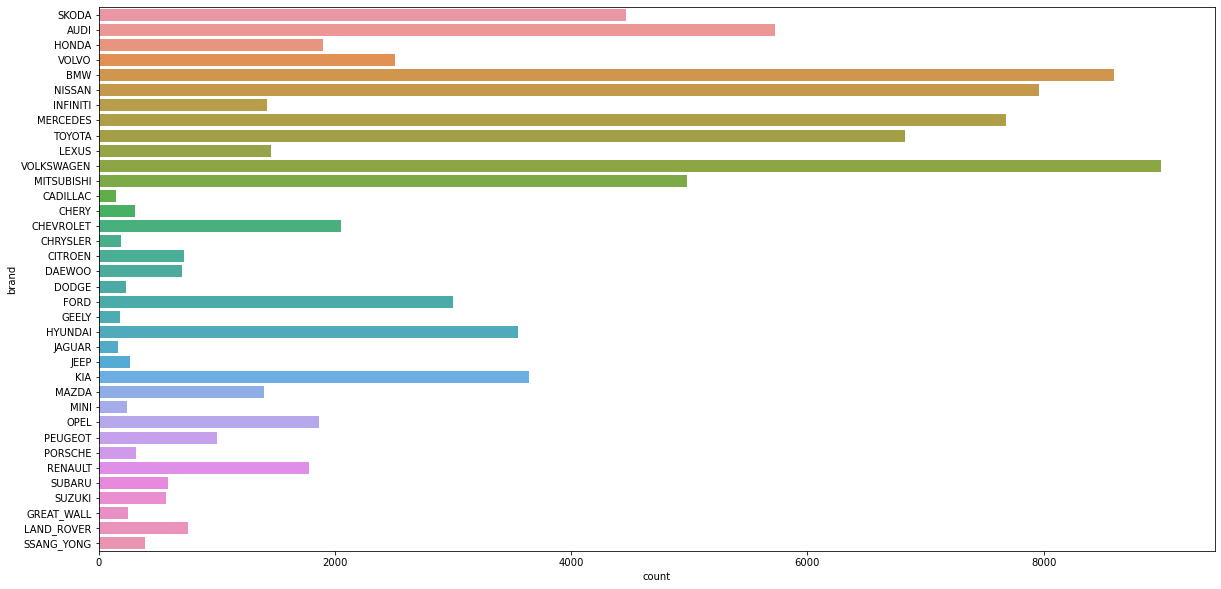

In [99]:
# Ранее мы определили что признак brand не имеет пропусков
# посмотрим на распределение
g = sns.countplot(y=data['brand'])
g.figure.set_figwidth(20)
g.figure.set_figheight(10)

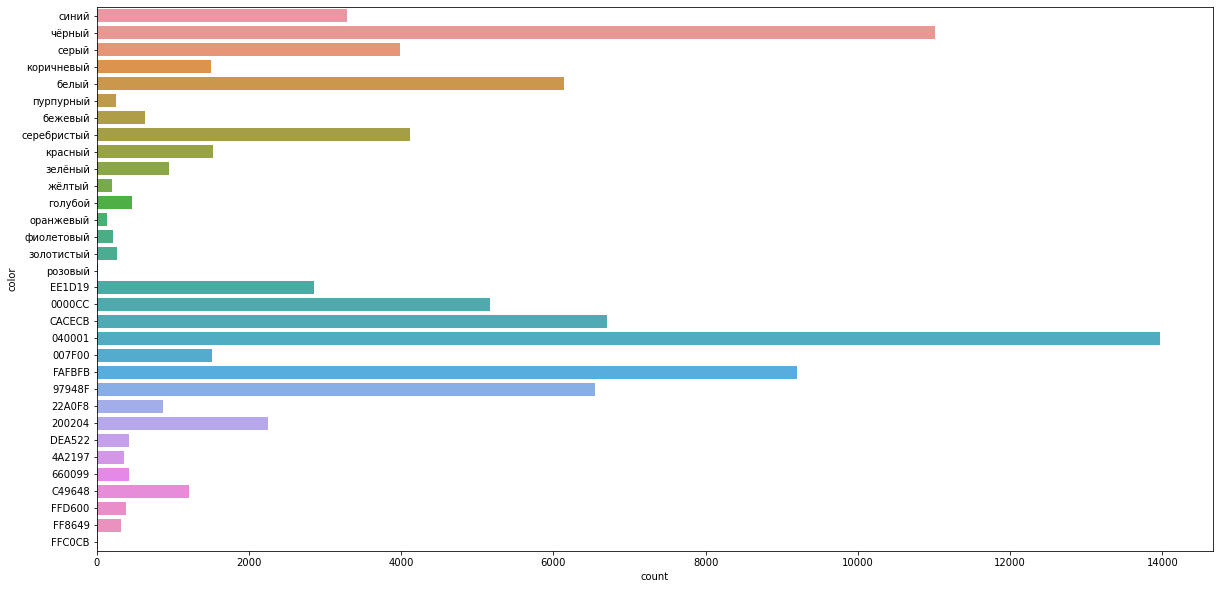

In [100]:
# посмотрим на распределение по цвету 'color'
g = sns.countplot(y=data['color'])
g.figure.set_figwidth(20)
g.figure.set_figheight(10)

<AxesSubplot:xlabel='count', ylabel='fuelType'>

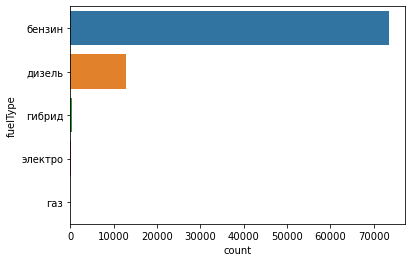

In [101]:
# посмотри на распределение по типу топлива
sns.countplot(y=data['fuelType'])

In [102]:
data['name'].unique()

array(['1.2 AMT (105 л.с.)', '1.6 MT (110 л.с.)',
       'DSG 1.8 AMT (152 л.с.)', ..., '2.8 AT (201 л.с.) 4WD',
       '2.3 AT (140 л.с.) 4WD', '2.7d AT (165 л.с.) 4WD'], dtype=object)

In [103]:
data['vehicleConfiguration'].unique()

array(['LIFTBACK ROBOT 1.2', 'LIFTBACK MECHANICAL 1.6',
       'LIFTBACK ROBOT 1.8', ..., 'ALLROAD_5_DOORS AUTOMATIC 2.3d',
       'PICKUP_TWO MECHANICAL Sports', 'MINIVAN AUTOMATIC 2.7d'],
      dtype=object)

In [104]:
data['vehicleTransmission'].unique()

array(['роботизированная', 'механическая', 'автоматическая', 'вариатор',
       'MECHANICAL', 'AUTOMATIC', 'ROBOT', 'VARIATOR'], dtype=object)

In [105]:
data['engineDisplacement'].unique()

array(['1.2 LTR', '1.6 LTR', '1.8 LTR', '2.0 LTR', '1.4 LTR', '1.3 LTR',
       '1.0 LTR', '3.6 LTR', '1.5 LTR', '1.9 LTR', '2.8 LTR', '1.1 LTR',
       '2.5 LTR', '4.2 LTR', '3.0 LTR', '4.0 LTR', '5.9 LTR', '2.7 LTR',
       '3.1 LTR', '2.4 LTR', '5.2 LTR', '3.2 LTR', '4.1 LTR', '6.3 LTR',
       '2.3 LTR', '6.0 LTR', '2.2 LTR', '3.7 LTR', '2.9 LTR', '5.0 LTR',
       '3.3 LTR', '2.1 LTR', '2.6 LTR', ' LTR', '3.5 LTR', '1.7 LTR',
       '0.7 LTR', '4.4 LTR', '4.8 LTR', '5.4 LTR', '6.6 LTR', '4.9 LTR',
       '3.8 LTR', '3.4 LTR', '3.9 LTR', '4.6 LTR', '5.6 LTR', '4.5 LTR',
       '5.5 LTR', '6.2 LTR', '4.7 LTR', '4.3 LTR', '5.8 LTR', '5.3 LTR',
       '5.7 LTR', '1.8', '2.3', '2.0', '2.8', '2.6', 'S4', '2.2', '2.5d',
       '2.1', '1.6', '1.9d', '1.6d', '1.3', '1.4', '1.2d', 'ultra', '1.2',
       '3.2', '1.5', '8V', '2.0d', '3.1', '2.4', '2.7d', '16V', '3.0',
       '7S-tronic', '3.0d', 'tiptronic', '40', '45', '2.7', '55', '4.2',
       'S-tronic', 'Tiptronic', 'Long', '4.0', '3.9d'

In [106]:
data['enginePower'].unique()

array(['105 N12', '110 N12', '152 N12', '200 N12', '102 N12', '150 N12',
       '90 N12', '180 N12', '220 N12', '122 N12', '70 N12', '140 N12',
       '125 N12', '54 N12', '86 N12', '75 N12', '64 N12', '95 N12',
       '260 N12', '170 N12', '80 N12', '68 N12', '160 N12', '115 N12',
       '280 N12', '53 N12', '60 N12', '143 N12', '42 N12', '101 N12',
       '58 N12', '193 N12', '79 N12', '30 N12', '100 N12', '50 N12',
       '163 N12', '225 N12', '420 N12', '211 N12', '245 N12', '560 N12',
       '500 N12', '249 N12', '450 N12', '605 N12', '250 N12', '354 N12',
       '120 N12', '290 N12', '230 N12', '350 N12', '204 N12', '255 N12',
       '340 N12', '177 N12', '272 N12', '372 N12', '210 N12', '130 N12',
       '300 N12', '190 N12', '239 N12', '435 N12', '333 N12', '271 N12',
       '326 N12', '238 N12', '310 N12', '233 N12', '252 N12', '133 N12',
       '460 N12', '520 N12', '400 N12', '525 N12', '367 N12', '265 N12',
       '550 N12', '580 N12', '88 N12', '165 N12', '430 N12', '335 N

In [107]:
# 
data['description'].unique()

array(['Все автомобили, представленные в продаже, проходят тщательную проверку по более 40 параметрам. Предоставляем гарантию юридической чистоты, а так же год технической гарантии на двигатель и КПП. Бесплатный тест-драйв. Возможно оформление автомобиля в кредит!\n\nПреимущества автокредитования:\n— Первоначальный взнос от 0%;\n— Более 30 кредитных программ;\n— Процентная ставка от 6% годовых;\n— Срок кредита от 6 месяцев до 7 лет;\n— Оформление кредита по двум документам;\n— Досрочное погашение без штрафов и комиссий;\n— Сумма кредита до 2 млн рублей;\n— Оформление КАСКО – по желанию;\n— Без справок и поручителей.\n\nСотрудничаем с 12 аккредитованными и сертифицированными банками РФ, среднее время ожидания решения банка 20–30 минут.\n\nПри покупке автомобиля по программе «Trade-in – выгодный обмен» или в кредит, получите дополнительную скидку до 80 000 рублей на данный автомобиль!\n\nЗаписаться на тест-драйв, а так же получить подробную информацию можно у специалистов автоцентра по у

In [108]:
data['model_name'].unique()

array(['OCTAVIA', 'SUPERB', 'OCTAVIA_RS', ..., 'REXTON', 'RODIUS',
       'STAVIC'], dtype=object)

In [109]:
data['Владельцы'].value_counts()

3.0            20683
3 или более    15957
2.0            12500
1.0            12185
1 владелец      9459
2 владельца     9270
Name: Владельцы, dtype: int64

In [110]:
data['Привод'].value_counts()

передний    45383
полный      33355
задний       8133
Name: Привод, dtype: int64

### Промежуточные выводы:

- признак ***bodyType*** имеет множество значений, необходим label encoding.
- признак ***Brand*** имеет множество значений с нормальным распределением, необходим label encoding.
- признак ***color*** имеет разные типы представления цвета.
- признак ***name*** имеет множество значений, необходим label encoding.
- признак ***model_name***  имеет множество значений, необходим label encoding.
- признак ***engineDisplacement*** имеет множество значений, необходим label encoding.
- признак ***description*** - содержит описание, имеет много пропусков и не без глубокой обработки не несет в себе полезной информации. Принимаю решение удалить данный признак.
- признаки ***vehicleConfiguration***. Имееют разрозненные данные имеющиеся в других признаках. Избавимся от них.
- признак ***Топливо***. принимает 3 значения, использую его как dummy переменные.
- признак ***vehicleTransmission***. Принимает 4 значения, но на разных языках, требует обработки.
- признак ***Владельцы*** - Имеет пропуски, принимает 3 значения требующие обработку. Пропущенные значение заполним модой: '3'.
- признак ***Привод***. принимает 3 значения, использую его как dummy переменные.
- признак ***enginePower*** на самом деле является числовым, требует соответствующей обработки.

In [111]:
# Удалим обозначенные признаки
data.drop(['vehicleConfiguration', 'description'], axis=1, inplace=True)
cat_cols.remove('vehicleConfiguration')
cat_cols.remove('description')

In [112]:
# создадим dummy переменные топлива
data = pd.get_dummies(data, prefix='топливо', columns=['fuelType'])

In [113]:
# обработаем и создадим dummy переменные типа коробки передач
data = data.replace({'vehicleTransmission': {'роботизированная': 'ROBOT', 'механическая': 'MECHANICAL',
                                             'автоматическая': 'AUTOMATIC', 'вариатор': 'VARIATOR'}})
data = pd.get_dummies(data, prefix='vehicle', columns=['vehicleTransmission'])

In [114]:
# обработаем признак владельцы
data = data.replace({'Владельцы': {'3 или более': 3, '1\xa0владелец': 1,
                                   '2\xa0владельца': 2}})
data['Владельцы'] = data['Владельцы'].fillna(3)

# преобразуем количество владельцев в Int
data = data.astype({'Владельцы': np.int})

<ipython-input-114-06383caaf5ca>:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data = data.astype({'Владельцы': np.int})


In [115]:
# создадим dummy переменные привода
data = pd.get_dummies(data, prefix='Привод', columns=['Привод'])

In [116]:
# обработаем признак enginePower и добавим к числовым признакам
a = []
for x in data['enginePower']:
    t = str(x).replace(' N12', '')
    a.append(float(t))
data['power'] = a
data.drop(['enginePower'], axis=1, inplace=True)
cat_cols.remove('enginePower')
num_cols.append('power')

In [117]:
# сразу прологарифмируем признак
data['power'] = get_log(data, 'power')

In [118]:
# удалим из списка обработанные переменные
cat_cols.remove('fuelType')
cat_cols.remove('vehicleTransmission')
cat_cols.remove('Привод')

In [119]:
data[cat_cols]

,bodyType,brand,color,name,engineDisplacement,model_name,Владельцы
0,лифтбек,SKODA,синий,1.2 AMT (105 л.с.),1.2 LTR,OCTAVIA,3
1,лифтбек,SKODA,чёрный,1.6 MT (110 л.с.),1.6 LTR,OCTAVIA,1
2,лифтбек,SKODA,серый,DSG 1.8 AMT (152 л.с.),1.8 LTR,SUPERB,1
3,лифтбек,SKODA,коричневый,1.6 AT (110 л.с.),1.6 LTR,OCTAVIA,1
4,лифтбек,SKODA,белый,1.8 AT (152 л.с.),1.8 LTR,OCTAVIA,1
...,...,...,...,...,...,...,...
91265,Внедорожник 5 дв.,SSANG_YONG,040001,2.7d AT (186 л.с.) 4WD,2.7d,REXTON,1
91266,Внедорожник 5 дв.,SSANG_YONG,040001,2.7d AT (163 л.с.) 4WD,2.7d,REXTON,2
91267,Минивэн,SSANG_YONG,040001,2.7d AT (165 л.с.) 4WD,2.7d,RODIUS,1
91268,Минивэн,SSANG_YONG,040001,2.0d AT (149 л.с.) 4WD,2.0d,STAVIC,1


In [120]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86871 entries, 0 to 91269
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bodyType            86871 non-null  object 
 1   brand               86871 non-null  object 
 2   color               86871 non-null  object 
 3   modelDate           86871 non-null  float64
 4   name                86871 non-null  object 
 5   numberOfDoors       86871 non-null  float64
 6   productionDate      86871 non-null  float64
 7   engineDisplacement  86871 non-null  object 
 8   mileage             86871 non-null  float64
 9   Руль                86871 non-null  object 
 10  Состояние           34686 non-null  object 
 11  Владельцы           86871 non-null  int32  
 12  ПТС                 86658 non-null  object 
 13  Таможня             86871 non-null  object 
 14  price               86871 non-null  float64
 15  model_name          86871 non-null  object 
 16  samp

In [121]:
# проиводим кодировку категориальных признаков
for colum in ['bodyType', 'brand', 'color', 'name', 'engineDisplacement', 'model_name']:
    data[colum] = data[colum].astype('category').cat.codes

<AxesSubplot:>

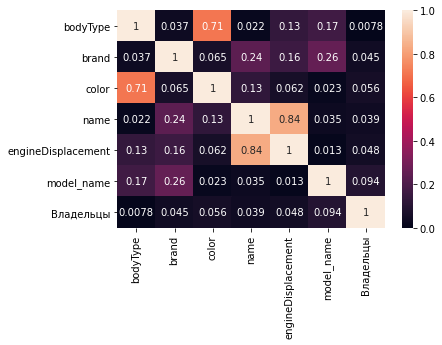

In [122]:
# Проведем корреляционный анализ категоральных признаков
sns.heatmap(data[cat_cols].corr().abs(), annot=True, vmin=0, vmax=1)

<AxesSubplot:>

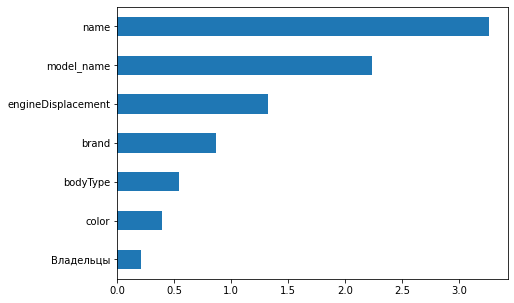

In [123]:
# определим значимость категориальных признаков с помощью функции mutual_info_classif
fig = plt.subplots(figsize=(7, 5))
imp_cat = pd.Series(mutual_info_classif(data.query('sample == 1')[cat_cols], data.query('sample == 1')['price'],
                                        discrete_features=True), index=cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

**Резюме**: Максимальное значение коэффициента корреляции составляет 0,84 между признаками ***name/engineDisplacement***. Это говорит о большой связи этих параметров, так как по значимости ***name*** занимает верхнюю позицию, избавимся от ***engineDisplacement***. Оценка значимости признаков показывает, что все признаки в той или иной степени влияют на целевой. Самым значимым из чиловых признаков является ***name***.

In [124]:
# Удалим признак engineDisplacement
data.drop(['engineDisplacement'], axis=1, inplace=True)
cat_cols.remove('engineDisplacement')

# Бинарные признаки

In [125]:
data[bin_cols].head()

,ПТС,Руль,Состояние,Таможня
0,Оригинал,Левый,Не требует ремонта,Растаможен
1,Оригинал,Левый,Не требует ремонта,Растаможен
2,Оригинал,Левый,Не требует ремонта,Растаможен
3,Оригинал,Левый,Не требует ремонта,Растаможен
4,Оригинал,Левый,Не требует ремонта,Растаможен


In [126]:
data = data.replace({'ПТС': {'Оригинал': 'ORIGINAL', 'Дубликат': 'DUPLICATE'}})
data['ПТС'] = data['ПТС'].fillna('DUPLICATE')

In [127]:
data = data.replace({'Руль': {'Левый': 'LEFT', 'Правый': 'RIGHT'}})

In [128]:
data['Таможня'].unique()

array(['Растаможен', True], dtype=object)

In [129]:
data['Состояние'].unique()

array(['Не требует ремонта', nan], dtype=object)

In [130]:
# В признаке таможня всего одно значение, для модели никакой информации не несет
# Аналогично в признаке Состояние
data.drop(['Состояние', 'Таможня'], axis=1, inplace=True)
bin_cols.remove('Состояние')
bin_cols.remove('Таможня')

In [131]:
# проведем Label Encoding бинарных признаков
le = LabelEncoder()
for column in bin_cols:
    data[column] = le.fit_transform(data[column])
    print(dict(enumerate(le.classes_)))

data[bin_cols].head()

{0: 'DUPLICATE', 1: 'ORIGINAL'}
{0: 'LEFT', 1: 'RIGHT'}


,ПТС,Руль
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


<AxesSubplot:>

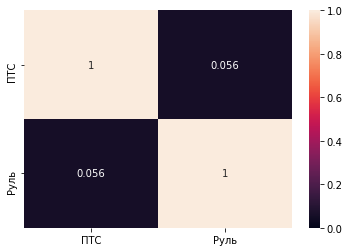

In [132]:
# Проведем корреляционный анализ бинарных признаков
sns.heatmap(data[bin_cols].corr().abs(), annot=True, vmin=0, vmax=1)

In [133]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86871 entries, 0 to 91269
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bodyType            86871 non-null  int16  
 1   brand               86871 non-null  int8   
 2   color               86871 non-null  int8   
 3   modelDate           86871 non-null  float64
 4   name                86871 non-null  int16  
 5   numberOfDoors       86871 non-null  float64
 6   productionDate      86871 non-null  float64
 7   mileage             86871 non-null  float64
 8   Руль                86871 non-null  int32  
 9   Владельцы           86871 non-null  int32  
 10  ПТС                 86871 non-null  int32  
 11  price               86871 non-null  float64
 12  model_name          86871 non-null  int16  
 13  sample              86871 non-null  int64  
 14  топливо_бензин      86871 non-null  uint8  
 15  топливо_газ         86871 non-null  uint8  
 16  топл

# Подготовка данных к обучению

In [148]:
# Разделим объединенный датасет на тренировочный и тестовый:
df_train = data.query('sample == 1').drop(['sample'], axis=1)
df_test = data.query('sample == 0').drop(['sample', 'price'], axis=1)
# Обозначаим целевой признак
y = df_train['price']

In [149]:
X = df_train.drop(['price'], axis=1)
X_sub = df_test

In [150]:
# Разбиваем данные на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)
print(
    f'Размер тренировочной выборки: {X_train.shape}\nРазмер валидационной выборки: {X_test.shape}')

Размер тренировочной выборки: (41748, 25)
Размер валидационной выборки: (10437, 25)


In [145]:
# Стандартизация данных ухудшила показатели при обучении.
'''
standart_scaler = StandardScaler()
X_train = standart_scaler.fit_transform(X_train)
X_test = standart_scaler.fit_transform(X_test)
print(X_train.shape, X_test.shape)
'''

(41748, 25) (10437, 25)


# Model 1: RandomForestRegressor

In [165]:
# Попробуем обучить модель со стандартными параметрами
model = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1)

model.fit(X_train, np.log(y_train))
model_pred = np.exp(model.predict(X_test))

print(
    f"Точность модели по метрике MAPE: {(mape(y_test, model_pred))*100:0.2f}%")

Точность модели по метрике MAPE: 12.76%


In [1155]:
# посмотри какие параметры будут наилучшими для нашей модели
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
max_features = [10, 12, 14]
max_depth = [10, 15, 20, 25]
min_samples_split = [1, 2, 3]
bootstrap = [True, False]
random_grid = {'max_depth': max_depth,
               'n_estimators': n_estimators,
               'max_features': max_features,
               'min_samples_split': min_samples_split,
               'bootstrap': bootstrap}
rf = RandomForestRegressor(random_state=RANDOM_SEED)
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100,
                               cv=3, verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(X_train, y_train)
# посмотрим, какие гиперпараметры нам предлагают как оптимальные:
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.96852787 0.96869879 0.95893686 0.96886495        nan        nan
        nan 0.9685834  0.96876145        nan 0.9683639  0.95957459
        nan 0.96843085 0.95947071        nan 0.95927046        nan
        nan        nan 0.95959454        nan        nan        nan
 0.9695638  0.96888462 0.96872497        nan        nan 0.96859359
 0.95949019        nan        nan 0.95901281        nan        nan
        nan        nan 0.9689847  0.96929548        nan 0.968589
 0.95892927 0.96868522 0.95946634 0.95926447 0.96870264 0.96928198
 0.96932709 0.95926513 0.96894752 0.96874073 0.95952381 0.96919654
 0.96848264 0.96877525        nan        nan 0.95927924 0.96888887
 0.96897236 0.95805822 0.95925715        nan 0.9686126         nan
 0.96935136        nan 0.96896198 0.9692736         nan 0.95956151
 0.95923831 0.95901591 0.96859625 0.96906718 0.96895007

{'n_estimators': 1800,
 'min_samples_split': 3,
 'max_features': 10,
 'max_depth': 15,
 'bootstrap': False}

In [147]:
# обучим нашу модель с полученными параметрами
model = RandomForestRegressor(n_estimators=1800, min_samples_split=3, max_features=10,
                              max_depth=15, bootstrap=False, random_state=RANDOM_SEED, n_jobs=-1)

model.fit(X_train, np.log(y_train))
model_pred = np.exp(model.predict(X_test))

print(
    f"Точность модели по метрике MAPE: {(mape(y_test, model_pred))*100:0.2f}%")

Точность модели по метрике MAPE: 13.32%


# Model 2: ExtraTreesRegressor

In [1152]:
model = ExtraTreesRegressor(random_state=RANDOM_SEED, n_jobs=-1)

model.fit(X_train, np.log(y_train))
model_pred = np.exp(model.predict(X_test))

print(
    f"Точность модели по метрике MAPE: {(mape(y_test, model_pred))*100:0.2f}%")

Точность модели по метрике MAPE: 13.09%


In [1158]:
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
max_features = [10, 12, 14]
max_depth = [10, 15, 20, 25]
min_samples_split = [2, 3, 4]
bootstrap = [True, False]
random_grid = {'max_depth': max_depth,
               'n_estimators': n_estimators,
               'max_features': max_features,
               'min_samples_split': min_samples_split,
               'bootstrap': bootstrap}
etr = ExtraTreesRegressor(random_state=RANDOM_SEED)
etr_random = RandomizedSearchCV(estimator=etr, param_distributions=random_grid, n_iter=100,
                                cv=3, verbose=2, random_state=42, n_jobs=-1)
etr_random.fit(X_train, y_train)
# посмотрим, какие гиперпараметры нам предлагают как оптимальные:
etr_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.96521726 0.96405779 0.93127887 0.96393258 0.95875524 0.93552788
 0.93571493 0.95893091 0.96392883 0.93055181 0.96694339 0.9346547
 0.9312444  0.95734282 0.9340491  0.96467686 0.93525667 0.96672691
 0.96514054 0.96470263 0.93456016 0.92394815 0.9313504  0.96667443
 0.95847087 0.96460093 0.96515422 0.96450807 0.95954415 0.9595306
 0.93038645 0.92406575 0.96553163 0.92406379 0.96629534        nan
        nan 0.96557002 0.96630451 0.9607649  0.96506404 0.95945421
 0.93128324 0.96693275 0.9303545  0.93545249 0.96538951 0.96636388
 0.96626976 0.93536247 0.9621553  0.96666025 0.93480458 0.96631114
 0.95948352 0.96508357 0.96462638 0.96477174 0.93528717 0.96468601
 0.96190962 0.92494046 0.93531882 0.93073561 0.9650612  0.95760026
 0.96625205 0.96088517 0.96219129 0.96634557 0.96638713 0.93055332
 0.93544503 0.92469184 0.95891439 0.96194913 0.96618153

{'n_estimators': 1400,
 'min_samples_split': 3,
 'max_features': 14,
 'max_depth': 25,
 'bootstrap': False}

In [1159]:
# обучим нашу модель с полученными параметрами
model = ExtraTreesRegressor(n_estimators=1400, min_samples_split=3, max_features=14,
                            max_depth=25, bootstrap=False, random_state=RANDOM_SEED, n_jobs=-1)

model.fit(X_train, np.log(y_train))
model_pred = np.exp(model.predict(X_test))

print(
    f"Точность модели по метрике MAPE: {(mape(y_test, model_pred))*100:0.2f}%")

Точность модели по метрике MAPE: 12.84%


# Model 3: GradientBoostingRegressor

In [1184]:
model = GradientBoostingRegressor(random_state=RANDOM_SEED)
model.fit(X_train, np.log(y_train))
model_pred = np.exp(model.predict(X_test))

print(
    f"Точность модели по метрике MAPE: {(mape(y_test, model_pred))*100:0.2f}%")

Точность модели по метрике MAPE: 17.85%


In [1160]:
param_grid = {'learning_rate': [0.01, 0.1, 0.5, 0.7],
              'subsample': [0.9, 0.5, 0.2, 0.1],
              'n_estimators': [100, 500, 1000, 1500],
              'max_depth': [2, 4, 6]
              }
gbs = GradientBoostingRegressor(random_state=RANDOM_SEED)
gbs_best = GridSearchCV(estimator=gbs, param_grid=param_grid, cv=2, n_jobs=-1)
gbs_best.fit(X_train, y_train)
gbs_best.best_params_

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 1500, 'subsample': 0.9}

In [1165]:
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor(
    n_estimators=1500, learning_rate=0.1, max_depth=5, subsample=0.9, random_state=RANDOM_SEED)
model.fit(X_train, np.log(y_train))
model_pred = np.exp(model.predict(X_test))

print(
    f"Точность модели по метрике MAPE: {(mape(y_test, model_pred))*100:0.2f}%")

Точность модели по метрике MAPE: 12.08%


# Model 4: CatBoost

In [161]:
cbr = CatBoostRegressor(iterations=5000,
                          random_seed=RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                          )
cbr.fit(X_train, np.log(y_train),
          # cat_features=cat_features_ids,
          eval_set=(X_test, np.log(y_test)),
          verbose_eval=0,
          use_best_model=True,
          # plot=True
          )
model_pred = np.exp(cbr.predict(X_test))

print(
    f"Точность модели по метрике MAPE: {(mape(y_test, model_pred))*100:0.2f}%")

Точность модели по метрике MAPE: 11.87%


# Staking

In [160]:
# Стакинг с использованием StackingRegressor

estimators = [
    ('etr', ExtraTreesRegressor(n_estimators = 1400, min_samples_split = 3, max_features = 14,
                            max_depth = 25, bootstrap = False, random_state=RANDOM_SEED, n_jobs=-1)),
    ('dtr', DecisionTreeRegressor(random_state=RANDOM_SEED))
]
reg = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(n_estimators = 1800, min_samples_split = 3,
                            max_depth = 15, bootstrap = False, random_state=RANDOM_SEED, n_jobs=-1)
)

reg.fit(X_train, np.log(y_train))
model_pred = np.exp(reg.predict(X_test))

print(
    f"Точность модели по метрике MAPE: {(mape(y_test, model_pred))*100:0.2f}%")

Точность модели по метрике MAPE: 14.83%


In [1178]:
# Стакинг с использованием ML-Ensemble

ensemble = SuperLearner()
estimators = [
    RandomForestRegressor(n_estimators = 1800, min_samples_split = 3, max_features = 10,
                            max_depth = 15, bootstrap = False, random_state=RANDOM_SEED, n_jobs=-1),
    GradientBoostingRegressor(n_estimators=1500, learning_rate = 0.1, max_depth = 5,subsample= 0.9, random_state=42),
    ExtraTreesRegressor(n_estimators = 1400, min_samples_split = 3, max_features = 14,
                            max_depth = 25, bootstrap = False, random_state=RANDOM_SEED, n_jobs=-1)
]
meta_estimator = [LinearRegression()]
ensemble.add(estimators)
ensemble.add_meta(meta_estimator)

ensemble.fit(X_train, np.log(y_train))
model_pred = np.exp(ensemble.predict(X_test))

print(f"Точность модели по метрике MAPE: {(mape(y_test, model_pred))*100:0.2f}%")

Точность модели по метрике MAPE: 11.85%


**Резюме**: Мной были опробованы 4 регрессионных модели и два варинта построения ансамблей (стакинг), на тесте лучший результат МАРЕ показал ансамбль с использованием ML-Ensemble: 11.85%, однако на сабмите лучший результат у модели обучения с применением CatBoost: 17.79%.

In [162]:
predict_test = np.exp(cbr.predict(X_test))
predict_submission = np.exp(cbr.predict(X_sub))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 11.87%


# Submission

In [164]:
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_2_v15.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,5.954416e+05
1,1100549428,7.738200e+05
2,1100658222,9.318834e+05
3,1100937408,6.336655e+05
4,1101037972,7.169601e+05
5,1100912634,6.820886e+05
6,1101228730,5.974865e+05
7,1100165896,3.453684e+05
8,1100768262,1.424246e+06
9,1101218501,8.430094e+05
